# Part 1: Setup Project

## Objective

General setup:

- Install dependencies, import TensorFlow Layers
- Config GPU


## 1.1 Install and import dependencies

First create a virtual environment for the project

**Uncommet some code lines if you run this notebook for the first time**


In [1]:
# Run these comments in the same project directory to create a virtual environment
#%python3 -m venv venv

# Activate the virtual environment
#%source venv/bin/activate

Then install the dependencies

In [2]:
#%pip install tensorflow 

In [3]:
#%pip install opencv-python

In [4]:
#%pip install matplotlib

In [5]:
#%pip install scikit-learn

In [6]:
# %pip install seaborn

Now import some necessary dependencies

In [7]:
import cv2 # OpenCV
import os  # For file operations
import random
import numpy as np
from matplotlib import pyplot as plt # For plotting graphs
from mtcnn.mtcnn import MTCNN
from numpy import savez_compressed
from PIL import Image

2024-11-02 09:33:47.085268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-02 09:33:47.113435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 09:33:47.145822: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 09:33:47.155496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-02 09:33:47.180166: I tensorflow/core/platform/cpu_feature_guar

In [8]:
# Import TensorFlow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D,  Dense, MaxPool2D, Flatten, Input
import tensorflow as tf


- Conv2D for Convolutional Neural Networks
- Dense for Fully Connected Neural Networks
- MaxPooling2D to pull our layers together and effectively reduce the number of parameters and computations in the network
- Flatten take output from previous layer and flatten it to a vector to be fed into the next layer

In [9]:
# Defined the Camera ID to use
CAM_ID = 3 # Establishing the connection with the IR camera


## 1.2 Setup GPU Limit for TensorFlow

In [11]:
# Avoid Memory Error when TensorFlow use two much VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [12]:
gpus # Show all GPUs available in machine

[]

# Part 2: Preprocess Data, Detect faces and create training data 
## Objective

- Build funtion to preprocess image
- Detect faces in images and crop them to only contain the face, store in a compressed format
- Create positive and negative pairs with their labels


## 2.1 Preprocess Image function


We define a function to preprocess the images. The function accepts the inpput as the image path (string format) or the frame (numpy array format). 

Why we need two of these:

- When we want to process the images to create the dataset, provide image path to load images from the disk

- When we want to verify the image directly from the camera, provide the frame object by OpenCV to the function. (we do this in Part 7)


Note that to use the Gaussian Smoothing filter, I defined a function `gaussian_blur` that accepts the image and the kernel size as the input.

In [11]:
def gaussian_blur(image, kernel_size=(3,3), sigma=0.1):
    """
    Apply Gaussian blur to an image using TensorFlow with auto-determined sigma.
    
    Args:
    - image: Input image tensor
    - kernel_size: Size of the Gaussian kernel (height, width)
    
    Returns:
    - Smoothed image
    """
    
    # Ensure the image is a tensor
    if not isinstance(image, tf.Tensor):
        image = tf.convert_to_tensor(image)
    
    # Ensure 4D tensor [batch, height, width, channels]
    if len(image.shape) == 3:
        image = image[tf.newaxis, :, :, :]
    
    # Create Gaussian kernel for each channel
    def create_gaussian_kernel(size, sigma=1.0):
        """Generate a 2D Gaussian kernel"""
        size = int(size)
        x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
        g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
        return g / g.sum()
    
    # Create kernel
    kernel_height, kernel_width = kernel_size
    kernel = create_gaussian_kernel(kernel_height, sigma)
    
    # Expand kernel for all channels
    num_channels = image.shape[-1]
    kernel_4d = np.expand_dims(kernel, axis=-1)
    kernel_4d = np.repeat(kernel_4d, num_channels, axis=-1)
    kernel_4d = np.expand_dims(kernel_4d, axis=-1)
    
    # Convert kernel to float32 tensor
    kernel_tensor = tf.convert_to_tensor(kernel_4d, dtype=tf.float32)
    
    # Apply convolution
    blurred = tf.nn.depthwise_conv2d(
        input=image, 
        filter=kernel_tensor, 
        strides=[1, 1, 1, 1], 
        padding='SAME'
    )
    
    # Remove batch dimension if it was added
    return blurred[0] if blurred.shape[0] == 1 else blurred

Then now it is the preprocessing function

In [19]:
def preprocess(input_data):
    """
    Preprocess image data from various input formats into a standardized tensor.
    
    Args:
    input_data: Can be a file path (str), bytes tensor, numpy array, or PIL Image
    
    Returns:
    A preprocessed tensor of shape (100, 100, 3) with values in [0,1]
    """
    try:
        # Handle PIL Image input
        if isinstance(input_data, Image.Image):
            input_data = np.array(input_data)
        
        # Image decoding and initial processing
        if isinstance(input_data, (str, bytes)) or (isinstance(input_data, tf.Tensor) and input_data.dtype == tf.string):
            # Convert tensor to string if needed
            if isinstance(input_data, tf.Tensor):
                input_data = input_data.numpy()
            if isinstance(input_data, bytes):
                input_data = input_data.decode('utf-8')
            
            # Read and decode the image
            byte_image = tf.io.read_file(input_data)
            image = tf.image.decode_jpeg(byte_image, channels=3)
        else:
            # Handle numpy array or TensorFlow tensor input
            image = tf.convert_to_tensor(input_data)
        
        # Convert to float32
        image = tf.cast(image, tf.float32)
        
        # Ensure shape is correct
        if len(image.shape) != 3:
            raise ValueError(f"Expected image with 3 dimensions, got shape {image.shape}")
        
        # Resize the image
        image = tf.image.resize(image, (100, 100))
        
        # Smooth the image
        image = gaussian_blur(image, kernel_size=(3,3), sigma=0.1)
        
        # Normalize the image
        # WIth deep learing, it is ensential to normalize, so   can improve model 
        # performance by ensuring that input data is within a smaller, consistent range, which can help with stability during training.
        image = image / 255.0  # Normalize to [0,1]

        '''
        However, scaling might make the image look lower quality because of the smaller numerical range (0-1), even though 
        this does not actually affect its visual structure when used in a deep learning model. This step is not 
        meant for direct visualization, but rather for preparing data for model input.

        If you are trying to visually inspect the image to verify it after scaling, you can:
        '''
        
        return image
    
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        print(f"Input type: {type(input_data)}")
        if isinstance(input_data, (str, bytes)):
            print(f"Input path: {input_data}")
        raise
# Note that our preprocess function return a Tensorflow tensor, not a numpy array, so when need  to  perform image 
# with OpenCV, we need to convert it to numpy array

# Wrap the preprocess function in a tf.py_function to deal with Frame objects in Opencv
def preprocess_wrapper(input_data):
    """Wrapper function to use with tf.py_function if needed"""
    return tf.py_function(preprocess, [input_data], tf.float32)

Ham nay can them phan xu ly image. Truoc mat da xu ly crop. Can xu ly enhance contrast, brightness, sharpen, noise reduction, etc. ????

The correct dimension to resize will base on the model we use. For example:

- VGGFace: 224x224
- Facenet: 160x160
- ....

In this case, we use the Siamese model, the input size is 105x105, but we resize the image to 100x100, still work well.

**Thu tim them cac model khac va kich thuoc anh phu hop????**


Test the `prepreprocess` function with an example image:

testing with image: ./data/Steve_Avery/Steve_Avery_0001.jpg
Image  size before preprocessing: (250, 250, 3)


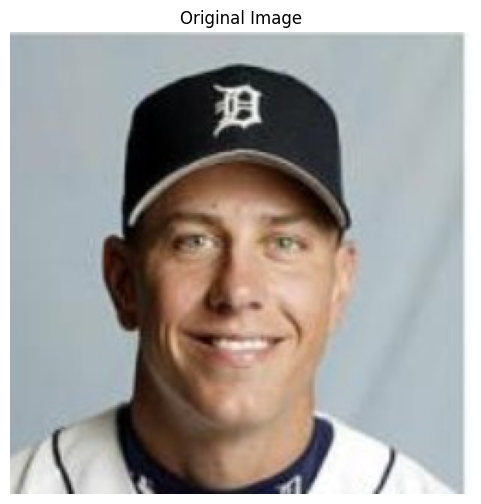

Image size after preprocessing: (100, 100, 3)


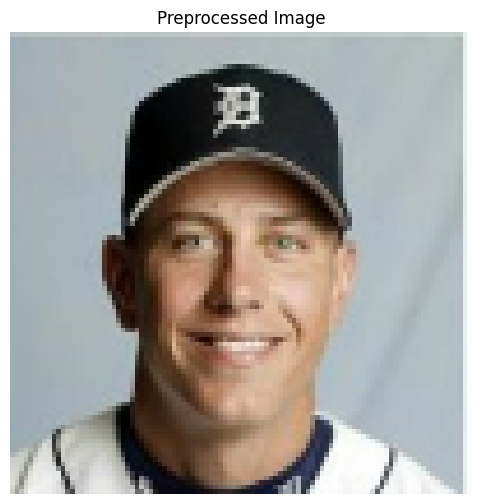

In [20]:
# Testing with an image inside the first subfolder inside ./data
# Path to an example image in the first subfolder
example_image_path = os.path.join('./data', os.listdir('./data')[0], os.listdir(os.path.join('./data', os.listdir('./data')[0]))[0])

print("testing with image:", example_image_path)

# Image before preprocessing
print("Image  size before preprocessing:", cv2.imread(example_image_path).shape)
plt.figure(figsize=(6,6))
# Display using RGB channel
plt.imshow(cv2.cvtColor(cv2.imread(example_image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')
plt.show()


# Image after preprocessing
print("Image size after preprocessing:", preprocess(example_image_path).shape)
plt.figure(figsize=(6,6))
# Display using RGB channel, resclae to [0,255], since the image after preprocessing is in [0,1], not for visualization
plt.imshow(tf.clip_by_value(preprocess(example_image_path) * 255, 0, 255).numpy().astype(np.uint8))

plt.title("Preprocessed Image")
plt.axis('off')
plt.show()



The iamge may look lower resolution, since we have resized it to 100x100. It gives lower resolution but reduce the computation cost and memory usage for the model.

## 2.2 Create Data Folder, detect faces and crop them, store in compressed format

In [21]:
# Create preprocessed_data(for Siamese) folder
os.makedirs('preprocessed_data(for_Siamese)', exist_ok=True)

# Inside that folder, create face_detect folder and face_embeddings folder
os.makedirs(os.path.join('preprocessed_data(for_Siamese)', 'face_detect'), exist_ok=True)

# since Siamese network base on feedback distance to update the extract features phase, we 
# can not have 'face_embeddings' folder at scratch

In [25]:
### Now, from the `data` folder, extract end align the faces (crop image to keep only face) 
# and save them in the `face_detect` folder ###


# Detect and extract faces from an image using MTCNN
# Parameters:
# - image_path: path to the image file
# - detector: MTCNN detector object
# - required_size: the size of the extracted face images (default is (160, 160))
def detect_and_extract_faces(image_path, detector, required_size=(160, 160)):
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    detections = detector.detect_faces(image_np)

    for detection in detections:
        x, y, width, height = detection['box']
        face = image_np[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize(required_size)
        
    return face_image

# Process a single subfolder (since the data folder contains subfolders for each person, use this function to process each subfolder)
# Parameters:
# - subfolder: the subfolder name in data folder we want to process
# - face_only_dataset_dir: the directory to save the extracted faces. This is the subfolder with person's name inside the face_detect folder

# - detector: MTCNN detector object
def process_subfolder(subfolder, face_only_dataset_dir, detector):
    subfolder_path = os.path.join('./data', subfolder) #Acessing the subfolder in ./data to collect names of people
    new_faces_folder = os.path.join(face_only_dataset_dir, os.path.basename(subfolder)) # with each name, create a new folder in face_detect folder
    
    # Create the new_faces_folder if it does not exist
    os.makedirs(new_faces_folder, exist_ok=True)
    
    image_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')] # For all images inside a person folder in the subfolder 
    faces = []
    
    i = 0 # Counter for the number of images in each subfolder
    for image_file in image_files:
       
        image_path = os.path.join(subfolder_path, image_file)
        face = detect_and_extract_faces(image_path, detector) # In this dataset, each of the image has only one face. 
        # If you want to apply with some dataset that has multiple faces in one image, use a loop here

        #  After extracting the face, preprocess the face image
        face_array = np.array(face) if not isinstance(face, np.ndarray) else face
        preprocessed_face = preprocess(face_array)

        # Save the face image
        face_image = Image.fromarray((preprocessed_face.numpy() * 255).astype(np.uint8))
        face_image_path = os.path.join(new_faces_folder, f'{os.path.splitext(image_file)[0]}_face_{i+1}.jpg')
        face_image.save(face_image_path)
        faces.append(face_image)

        i += 1

        
    # Also, save all faces inside the subfolder to a single .npz file
    # Ensure all faces have the same shape before saving to .npz
    if faces:
        # Convert Image objects to numpy arrays
        faces = [np.array(face) if isinstance(face, Image.Image) else face for face in faces]
        
        face_shape = faces[0].shape
        faces = [face for face in faces if face.shape == face_shape]
        faces = np.array(faces)
        print("Saving to faces.npz in", new_faces_folder)
        savez_compressed(os.path.join(new_faces_folder, 'faces.npz'), faces)
    else:
        print("No faces found in", subfolder)



`faces.npz` is just simply a compressed file that contains all list of numpy arrays, where each numpy array is a face image. 

In [26]:

# Main function to process all subfolders

detector = MTCNN()

# Except the README file, process all subfolders

for subfolder in os.listdir('./data'):
    if subfolder == 'README.md':
        continue
    print("Processing face detection for:", subfolder)
    process_subfolder(subfolder, './preprocessed_data(for_Siamese)/face_detect', detector)

Processing face detection for: Steve_Avery
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Steve_Avery
Processing face detection for: Nigel_Redden
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Nigel_Redden
Processing face detection for: Chang_Saio-yue
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Chang_Saio-yue
Processing face detection for: Hussein_Malik
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Hussein_Malik
Processing face detection for: Ali_Adbul_Karim_Madani
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Ali_Adbul_Karim_Madani
Processing face detection for: Sebastien_Grosjean
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Sebastien_Grosjean
Processing face detection for: Lionel_Chalmers
Saving to faces.npz in ./preprocessed_data(for_Siamese)/face_detect/Lionel_Chalmers
Processing face detection for: Roger_Machado
Saving to faces.npz in ./preprocessed_

First subfolder: Steve_Avery
Keys in the .npz file: ['arr_0']
Shape of faces array: (1, 100, 100, 3)
Shape of the first face: (100, 100, 3)


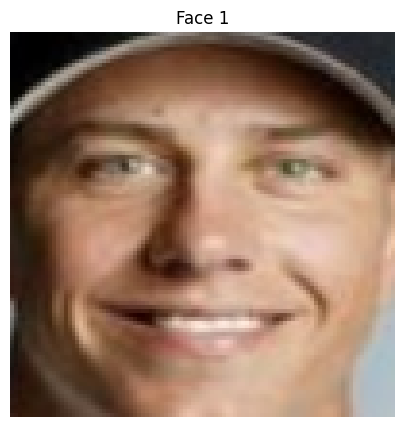

In [27]:
# Testing: load a faces.npz file in the first subfolder and display the faces

# Get the path to the first subfolder
first_subfolder = os.listdir('./preprocessed_data(for_Siamese)/face_detect')[0]
print("First subfolder:", first_subfolder)

# Load the .npz file
npz_file_path = os.path.join('./preprocessed_data(for_Siamese)/face_detect', first_subfolder, 'faces.npz')
test = np.load(npz_file_path)

# Print the keys in the .npz file
print("Keys in the .npz file:", test.files)

# Extract the faces array
faces = test['arr_0']

# Print the shape of the faces array
print("Shape of faces array:", faces.shape)

# Print the shape of the first face
face_shape = faces[0].shape
print("Shape of the first face:", face_shape)

# Plot the faces
plt.figure(figsize=(20, 5))
for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.axis('off')
    plt.title(f"Face {i+1}")
    plt.imshow(face)
plt.show()

## 2.3 Create pairs and labels for dataset

The Siamese network is integrated with preprocessing steps already, witohut sharing with the `DataPreprocessing.ipynb` notebook due to the approach of the model.

The process will be quite similar to the `DataPreprocessing.ipynb` notebook, but there will be some differences after the face detection step. 

In the `DataPreprocessing.ipynb` notebook, we used a pre train model to extract the the face embeddings. Just calling and it will do the job (aka, use model to give the prediction without training since it already pretrain model). However, in this Siamase Network, we even try to train the model how to extract these features.




Data organized into pairs:

     - Positive pairs: Two images of the same person
     - Negative pairs: Two images of different people
     
   - Training Process:
     - Network learns feature extraction from scratch
     - Pairs are fed through identical twin networks
     - Distance between feature vectors is computed
     - Loss function:
       * Minimizes distance for positive pairs
       * Maximizes distance for negative pairs
     - **Network iteratively improves feature extraction based on distance metrics**



In [29]:
# Now we create positive and negative pairs for the Siamese network


# Load face images from the .npz files
# Parameters:
# face_dir: directory containing the face images
def load_faces(face_dir):
    faces_dict = {}
    for subfolder in os.listdir(face_dir):  # Process each subfolder/person
        subfolder_path = os.path.join(face_dir, subfolder)
        if os.path.isdir(subfolder_path):
            data = np.load(os.path.join(subfolder_path, 'faces.npz'))
            faces = data['arr_0']
            faces_dict[subfolder] = faces
    return faces_dict  # Dictionary with key: person name, value: face images

# Create pairs of face images and corresponding labels
# Parameters: 
# faces_dict: dictionary containing face images of each person
# num_negative_samples: number of negative samples to create for each positive pair
# num_subfolders_to_sample: number of subfolders to sample for negative pairs
def create_pairs(faces_dict, num_negative_samples=5, num_subfolders_to_sample=3):
    pairs = []
    labels = []
    persons = list(faces_dict.keys())
    
    # Create positive pairs
    for person in persons:
        faces = faces_dict[person]
        for i in range(len(faces)):
            for j in range(i + 1, len(faces)):
                pairs.append([faces[i], faces[j]])
                labels.append(1)
    
    # Create negative pairs with random sampling
    for person in persons:
        faces = faces_dict[person]
        other_persons = [p for p in persons if p != person]
        sampled_persons = random.sample(other_persons, min(num_subfolders_to_sample, len(other_persons)))
        
        for face in faces:
            for sampled_person in sampled_persons:
                sampled_faces = faces_dict[sampled_person]
                sampled_negative_faces = random.sample(list(sampled_faces), min(num_negative_samples, len(sampled_faces)))
                
                for neg_face in sampled_negative_faces:
                    pairs.append([face, neg_face])
                    labels.append(0)
    
    return np.array(pairs), np.array(labels)

# Load face images
face_dir = './preprocessed_data(for_Siamese)/face_detect'
faces_dict = load_faces(face_dir)

# Create pairs and labels with random sampling for negative pairs
pairs, labels = create_pairs(faces_dict, num_negative_samples=1, num_subfolders_to_sample=1)
print("Number of pairs:", len(pairs))
print("Number of positive pairs:", sum(labels))  # since positive pairs are labeled as 1, negative are 0, 0 + 1 = 1
print("Number of negative pairs:", len(labels) - sum(labels))

# Prepare data
X = np.array([np.concatenate(pair) for pair in pairs])
y = labels

print("Shape of training data:", X.shape)
print("Shape of labels:", y.shape)





Number of pairs: 38
Number of positive pairs: 11
Number of negative pairs: 27
Shape of training data: (38, 200, 100, 3)
Shape of labels: (38,)


The output `Shape of training data: (46, 320, 160, 3)` provides information about the dimensions of your training dataset. Here's a breakdown of what each number represents:

- 46: This is the number of samples in your training dataset. In this case, you have 46 images.

- 200: This is the height of 2 image in pixels. Since we are handling 2 images in each pair

- 100: This is the width of each image in pixels. Each image in your dataset is 160 pixels wide.

- 3: This represents the number of color channels in each image. Typically, 3 channels correspond to the RGB color model (Red, Green, Blue) or BRG color model (Blue, Red, Green).

Each pairs is now coontain an anchor image and a validation image. If the validation image is the same person with the anchor image (call as positive image), the label is 1, otherwise, call as negative image, the label is 0.


Please  pay attendtion to the `num_negative_samples` and `num_subfolders_to_sample` parameters. Choose some values that the balance between the positive and negative samples, otherwise, the model will be biased to the negative samples. Or you can use some techinique to balance the dataset, such as oversampling, undersampling, etc.

In [37]:
# Convert pairs and labels to TensorFlow datasets
# From each pair of images(contains an anchor image + a validation image) and the corresponding label, create a TensorFlow dataset
data = tf.data.Dataset.from_tensor_slices((pairs,y))

# Shuffle and batch the dataset
BATCH_SIZE = 16
data = data.shuffle(buffer_size=1024).batch(BATCH_SIZE)

# Prefetch to improve performance
data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the dataset
for example_pairs, example_labels in data.take(1):
    anchor_images, validation_images = example_pairs[:, 0], example_pairs[:, 1]
    print("Anchor images shape:", anchor_images.shape)
    print("Validation images shape:", validation_images.shape)
    print("Labels shape:", example_labels.shape)

Anchor images shape: (16, 100, 100, 3)
Validation images shape: (16, 100, 100, 3)
Labels shape: (16,)


The output describes the shapes of the data and labels in a batch for a Siamese Network, which is typically used for tasks like image similarity or verification.

1. **Shape of pairs in a batch: (16, 2, 160, 160, 3)**
   - **16**: The batch size, meaning there are 16 pairs of images in each batch. Each pair/sample consists of two images and a label.
        - **2**: Each pair consists of 2 images.
        - **160, 160**: The height and width of each image, respectively.
        - **3**: The number of color channels in each image (usually RGB).

   So, each batch contains 16 pairs of images, and each image in the pair has a size of 160x160 pixels with 3 color channels.

2. **Shape of labels in a batch: (16,)**
   - **16**: The batch size, meaning there are 16 labels corresponding to the 16 pairs of images.

   Each label typically indicates whether the images in the pair are similar (e.g., 1) or dissimilar (e.g., 0).

In summary, each batch contains 16 pairs of images, and each image is 160x160 pixels with 3 color channels. There are also 16 labels, one for each pair, indicating the similarity between the images in the pair.

In [38]:
# Print out some labels of the dataset to see it it is well mixed yet

for pair, label in data.take(1):
    print("Labels in the batch:", label.numpy())
    

Labels in the batch: [1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1]


2024-11-02 10:01:14.029871: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Image 1 shape: (100, 100, 3)
Image 2 shape: (100, 100, 3)
Label: 0


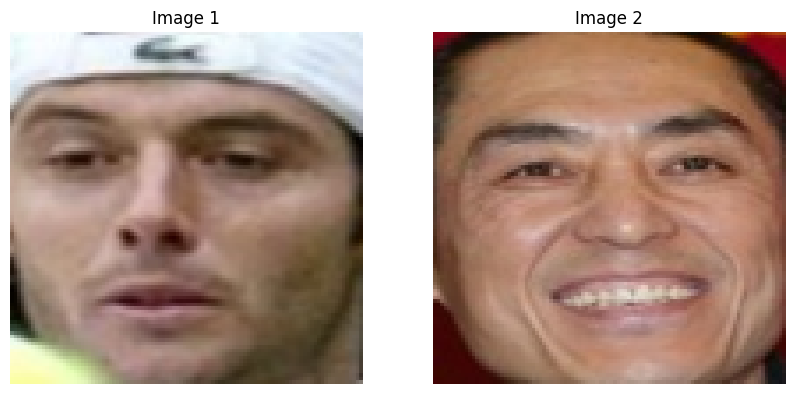

In [39]:
# Display an example sample with two iamges and the label

# Display an example sample with two images and the label
example_sample = next(iter(data))

# Unpack the example sample
example_pair, example_label = example_sample

# Display the images and the label
plt.figure(figsize=(10, 5))

# Display the first image in the pair
print("Image 1 shape:", example_pair[0][0].shape)
plt.subplot(1, 2, 1)
plt.imshow(example_pair[0][0])
plt.title("Image 1")
plt.axis("off")

# Display the second image in the pair
print("Image 2 shape:", example_pair[0][1].shape)
plt.subplot(1, 2, 2)
plt.imshow(example_pair[0][1])
plt.title("Image 2")
plt.axis("off")

# Print the label
print("Label:", example_label[0].numpy())

plt.show()

In [40]:
# Create Training and Testing datasets by percentage

train_data = data.take(int(0.8 * len(data))) # 80% of the data for training
test_data = data.skip(int(0.8 * len(data))) # 20% of the data for testing



In [41]:
print("Size of original dataset:", len(data))
print("Size of training dataset:", len(list(train_data.as_numpy_iterator())))
print("Size of test dataset:", len(list(test_data.as_numpy_iterator())))

Size of original dataset: 3
Size of training dataset: 2
Size of test dataset: 1


In [42]:
# Take an example batch from the training set
example_batch = next(iter(train_data))

# Unpack the example batch
example_pairs, example_labels = example_batch
example_input, example_validation = example_pairs[:, 0], example_pairs[:, 1]


# Display the shapes of the example batch
print("Shape of example anchor images :", example_input.shape)
print("Shape of example validation images :", example_validation.shape)
print("Shape of example labels:", example_labels.shape)

Shape of example anchor images : (16, 100, 100, 3)
Shape of example validation images : (16, 100, 100, 3)
Shape of example labels: (16,)


# Part 3: Build layers in model

## Objective

- Build an embedding layer / Encode Layer
- Create an L1 Distance layer
- Complie the Siamase Network

## 3.1 Build an Embedding Layer

Recall th idea, we have two stream of information (we  pass in two images: the anchor and the positive/negative image) -> Each stream will pass through an embedding layer to get the feature vector of the image -> Tow feature vectors will be used to calculate the distance between the two images at the Distance layer (here we use L1 distance).


Here is the Siamese Network architecture we are going to build:

![SiameseStructure](resources/images/SiameseStructure.png)

In the paper, it use input size of 105x105, but we will use 100x100 still okey. Therefore, **some numbers may not match exactly to the paper**

In [73]:
def make_embedding() :

    #Create the input layer
    inp = Input(shape=(100, 100, 3), name='input_image') # 100x100 image size, 3 channels color

   
    ### First Block ###
    # Next layer is a convolutional layer 64 filters, kernel size of 10x10, and ReLU activation
    c1= Conv2D(64, (10,10), activation='relu')(inp) # c1 stands for convolutional layer 1

    # Next layer is a max pooling layer with a pool size of 2x2
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) 



    ### Second Block ###
    # Next layer is a convolutional layer 128 filters, kernel size of 7x7, and ReLU activation
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    # Next layer is a max pooling layer with a pool size of 2x2
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)



    ### Third Block ###
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    ### Fourth Block ###
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4) # Flatten the output of the convolutional layer to feed it to the dense layer
    d1 = Dense(4096, activation='sigmoid')(f1) # Dense layer with 4096 neurons and sigmoid activation

    
    return Model(inputs=[inp], outputs=[d1], name='Siamese__embedding_layer')

As show in the above image, the output of the Embedding layer is a 4096-dimensional feature vector. Two streams of information will pass through this Embedding layer then we get two 4096-dimensional feature vectors for each image. **Basicaly, we are converting the face image to a 4096-dimensional feature vector.**

In [74]:
# Summary of the model
siamese_embedding_layer = make_embedding()
siamese_embedding_layer.summary()

Model: "Siamese__embedding_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

How to read from the summary table:

This is a 4-dimensional tensor shape where each dimension represents, for example (None,100,100,3):

- None: This represents the batch size dimension. It's set to "None" because it's flexible - you can feed any number of images through the network at once.
- 100: The height of your input images (100 pixels)
- 100: The width of your input images (100 pixels)
- 3: The number of color channels

So in plain terms, your model is expecting input images that are:

- 100x100 pixels in size
- Color in 3 channels, can be RGB, BRG or even just grayscale but duplicated 3 times to match the format.
- Can be processed in batches of any size (that's what the None indicates)

## 3.2 Create an L1 Distance Layer

Compare two feature vectors to see how similiar our two images are uisng L1 distance. The L1 distance is the sum of the absolute differences between the two feature vectors.

Since there is no L1 distance layer in Keras, we will create a custom layer to calculate the L1 distance. The custom layer will take two feature vectors as input and output the L1 distance between them.

In [75]:

class L1Dist(Layer):
    def __init__(self, **kwargs):
         super(L1Dist, self).__init__(**kwargs)
    
    def call(self,input_embedding, validation_embedding):
        
        # Convert inputs to tensors otherwise will meet error: unsupported operand type(s) for -: 'List' and 'List'
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        input_embedding = tf.squeeze(input_embedding, axis=0)  # Remove potential first dimension
        validation_embedding = tf.squeeze(validation_embedding, axis=0)

        # Calculate and return the L1 distance
        return tf.math.abs(input_embedding - validation_embedding)
    

## 3.3 Create final Siamese Network

We combine two above steps to make a fully Siamese model

In [76]:
def make_siamese_network():

    embedding_model = make_embedding()

    # Handle input images
    input_image = Input(shape=(100, 100, 3), name='input_image') # Anchor image
    validation_image = Input(shape=(100, 100, 3), name='validation_image') # Positive or negative image


    # Generate embeddings for the input images
    
    input_embedding = embedding_model(input_image)
    validation_embdedding = embedding_model(validation_image)

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(input_embedding, validation_embdedding)
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Fully_Siamese_Network')


In [77]:
# Create the model
fully_siamese_network = make_siamese_network()
fully_siamese_network.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Look at the summary table, we see that the input of the model is two images size 100,100,3. (How many images per batch is not specified, so it's flexible). The feature extraction vector (output of the Embedding layer) is **4096-dimensional**. 
The output is a **single value**, which is the distance between the two images.

# Part 4: Train the Siamese Network

## Objective

- Set up a loss function, set up an optimizer
- Establish checkpoints
- Build a Custom Training Step
- Create a Training Loop
- Train the model

## 4.1 Set up a loss function and an optimizer

In [78]:
#Define the loss function
binary_cross_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# from_logits=True is recommened when thr inputs to the loss function are not normalized 

What is this loss function?

![LossFunction](resources/images/Siamese-network_thumbnail.webp)

![LossFunction](resources/images/architecture-of-siamese-networks.webp)

![LossFunction](resources/images/The-Siamese-Architecture.png)

Beside using this Binary Crossentropy loss function, we can use other loss functions such as Contrastive Loss, Triplet Loss, etc, as this link: https://github.com/p16i/siamese-net-and-friends

In [79]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

There are tons of optimizer for Keras: SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Ftrl. We will use Adam optimizer.

## 4.2 Establish checkpoints

This checkpoint will save the model after each epoch. In case the training process is interrupted, we can resume the training from the last checkpoint.

In [80]:
# Create training_checkpoints directory in th machine
os.makedirs('./training_checkpoints', exist_ok=True)


checkpoint_dir = './training_checkpoints' # Directory to save the checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #Prefix for the checkpoint files with unique number
checkpoint = tf.train.Checkpoint(optimizer=optimizer, siamese_model=fully_siamese_network)

# To reload the model from the checkpoint, use model.load('path_to_checkpoint'). This will
# load pre trainweights and optimizer state into existing model

## 4.3 Build a Custom Training Step

In this step, we defined actual trainning steps. We train on one batch of data, one batch of data come through our training step, we go on makeing prediction -> calcualte our loss function -> calculate gradient then apply back popagation (calculate new weights and apply) through our neutral network to get the best possible model

In [81]:
@tf.function # Annotation to indicate that complies to TensorFlow graph execution 
def train_step(batch):

    with tf.GradientTape() as tape:  # Record operations for automatic differentiation
        
         # Get the pairs and labels from the batch
        pairs, labels = batch
        input_images, validation_images = pairs[:, 0], pairs[:, 1]
        
        # Forward pass
        predictions = fully_siamese_network([input_images, validation_images], training=True)
        # Set training=True for is important since some layers will only activated when this is set to True
    
    
        # Calculate the loss
        loss = binary_cross_loss(labels, predictions) # Measure the difference between the predicted value and the actual value
        print("Loss Vaule: ", loss)
    
        # Calculate the gradients
        gradients = tape.gradient(loss, fully_siamese_network.trainable_variables)

        # Update the weights and apply to the Siamese model
        optimizer.apply_gradients(zip(gradients, fully_siamese_network.trainable_variables))
        # Adam is a variant of stochastic gradient descent, it applies te learning rate and gradient to slightly reduce the loss function, unitll
        # it realy near the minimum value.



Recall the batch we created before:


In [82]:
# take one testing batch from train_data

example_batch = next(iter(train_data))
example_pairs, example_labels = example_batch
example_input, example_validation = example_pairs[:, 0], example_pairs[:, 1]


# Display the shapes of the example batch
print("Shape of example anchor images :", example_input.shape)
print("Shape of example validation images :", example_validation.shape)
print("Shape of example labels:", example_labels.shape)

Shape of example anchor images : (16, 100, 100, 3)
Shape of example validation images : (16, 100, 100, 3)
Shape of example labels: (16,)


## 4.4 Build Training Loop

In [83]:
## Define how the training loop will work ##

def train(data, EPOCHS): # EPOCHS is the number of times the model will see the entire dataset

    # Loop through the epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS)) # Print the current epoch to know the progress of runnig
        progressBar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run the training step here
            train_step(batch)
            progressBar.update(idx+1) # Update the progress bar

    # Save our checkpoint 
    if (epoch) % 10 == 0: # Save the model every 10 epochs
        checkpoint.save(file_prefix = checkpoint_prefix)

## 4.5 Train the model

What is Epoch mean in Deep Learning model training process?

An epoch in deep learning means one complete pass through the entire training dataset.
Think of it like this:

- If you have 1000 training images
- And you're training for 10 epochs
- Your model will see all 1000 images 10 times

Each epoch helps the model:

- Learn patterns from the data
- Adjust its weights and biases
- Improve its predictions

It's like reading a textbook multiple times - each pass (epoch) helps you understand the material better. However, too many epochs can lead to overfitting, where the model memorizes the training data instead of learning general patterns.

**Uncomment to train the model**, after training it and save, comment the code to avoid retrain the model again., just load the model and use it for the next steps.

In [84]:
# Define the number of epochs
EPOCHS = 1 # Increase for better results
# Modify the train_step function to handle the new batch structure

train(train_data, EPOCHS)


 Epoch 1/1


/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image']. Received: the structure of inputs=*
  warnings.warn(
/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Loss Vaule:  Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step


In [85]:
# Load the model from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Part 5: Envaluating Model

## Objective

- Evaluate the model
- Save the model for deployment


## 5.1 Envaluate the model

In this project, we will focus on enveluating **precision** and **recall**.

- Precision: The proportion of positive identifications that were actually correct.

- Recall: The proportion of actual positives that were identified correctly.

In [86]:
# Import metrics to evaluate the model
from tensorflow.keras.metrics import  Precision, Recall

In [87]:
# Example a batch of test data
test_pair, test_labels = test_data.as_numpy_iterator().next()
test_input, test_validation = test_pair[:, 0], test_pair[:, 1]
len(test_input) # Should be 16 since we have a batch size of 16 images

6

In [88]:
# Make predictions
predictions = fully_siamese_network([test_input, test_validation])
predictions

# In each time, we passs in a batch (containing 16 anchor images + 16 positive/negative images) to the model, then we get 16 predictions for each

<tf.Tensor: shape=(6, 1), dtype=float32, numpy=
array([[0.29252008],
       [0.3188292 ],
       [0.29739818],
       [0.25948685],
       [0.23171939],
       [0.33840284]], dtype=float32)>

In [89]:
# The return result for each prediction is the probability of the image pair being similar (1) or not (0), mean the return value is in the range of [0,1]
# So, we need some post processing the results by using threshold
res = []
for prediction in predictions:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)

res

[0, 0, 0, 0, 0, 0]

In [91]:
## Recall ##

# Create a metric object to evaluate the model
recall = Recall()

# Update the state of the metric object
recall.update_state(test_labels, res)

# Get the result of the metric
recall.result().numpy()


0.0

In this testing, I get the result 1.0, indicate that the model is perfect in **accuracy indentify us vs others people**. However, this is just on a batch, not the whole test_data, so not the final result

In [92]:
## Precision ##

# Similiarly, we can use the Precision metric to evaluate the model
precision = Precision()
precision.update_state(test_labels, res)
precision.result().numpy()

0.0

For more intiutive, we visualize the results

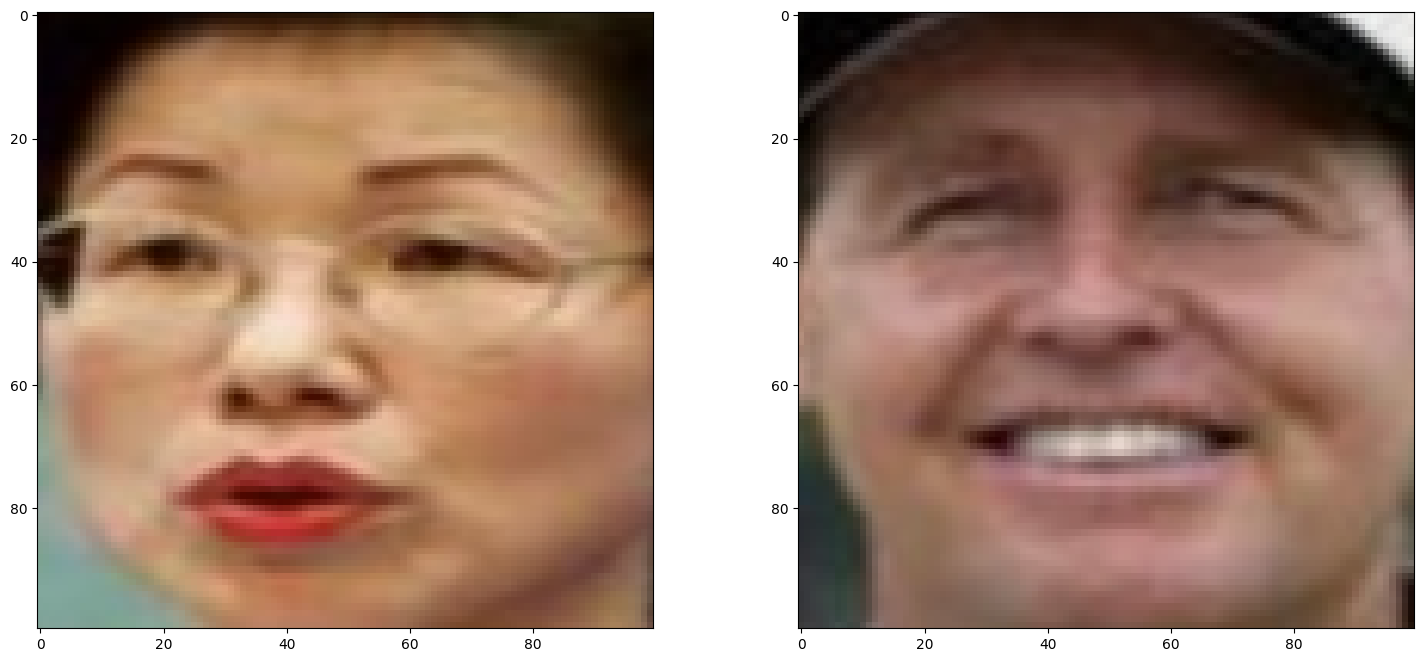

NOT the same person


In [93]:
sample_in_batch = 0 # Choose the first image in the batch

# Set plot size
plt.figure(figsize=(18,8))

# Set subplot. The subplot function allows you to render using a grid like format
# The first argument is the number of rows, the second is the number of columns, 
# and the third is the index of the current plot
plt.subplot(1,2,1)

plt.imshow(test_input[sample_in_batch])
plt.subplot(1,2,2)
plt.imshow(test_validation[sample_in_batch])
plt.show()

# Show the label
if (test_labels[sample_in_batch] == 1):
    print("Same person")
else:
    print("NOT the same person")

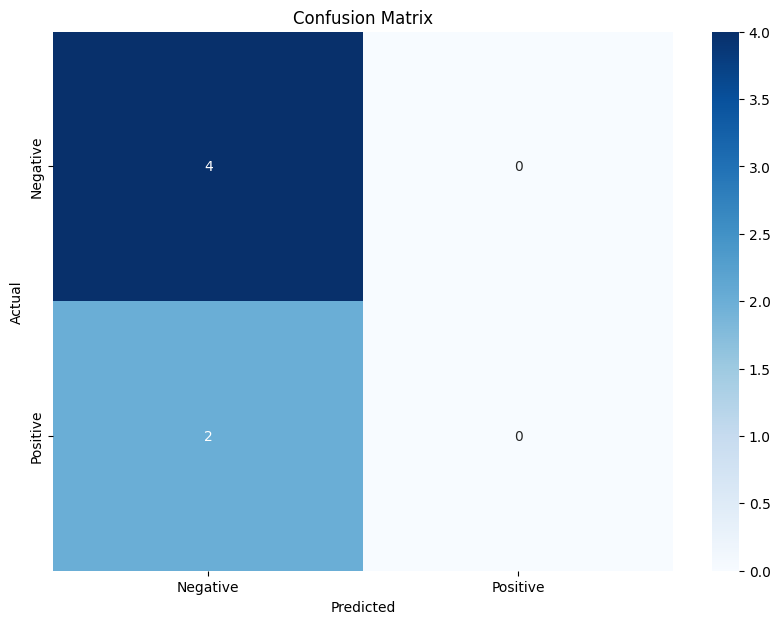

Precision: 0.0
Recall: 0.0


/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
# That is the result for an exmample batch, not we apply to the whole test data: draw the cofusion matrix and calculate the precision and recall and als
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns


# Create empty lists to store the predictions and labels
predictions = []
labels = []

# Loop through the test data
for batch in test_data:
    # Get the input images, validation images and labels from a batch
    test_pair, test_labels = batch
    test_input, test_validation = test_pair[:, 0], test_pair[:, 1]
    # Make predictions
    preds = fully_siamese_network([test_input, test_validation])
    # Append the predictions and labels to the lists
    predictions.extend(preds)
    labels.extend(test_labels) 

# Convert the lists to numpy arrays
predictions = np.array(predictions)
labels = np.array(labels)

# Apply a threshold to the predictions
threshold = 0.5
predictions = (predictions > threshold).astype(int)


# Calculate the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')



## 5.2 Save the model

**Uncomment to save the model when run the notebook for the first time**, after that, comment the code to avoid save the model again.

In [95]:
#First, we save our model weights
fully_siamese_network.save('model_saved/fully_siamese_network.h5')

Load the model from saved file

In [96]:
## Load the model from the saved file ##
import tensorflow as tf
# Reload the model
model = tf.keras.models.load_model('model_saved/fully_siamese_network.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy},
                                   compile=False)
# Without complie=false cause Warning: WARNING:absl:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


load_weights method can be used to load the weight also. The save_weights() method saves only the weights, the save() method saves optmizer state as well

The first parameter is the path to save the model, the second parameter is going to load our custom layers/objects. Because we got these inside our notebook alreadly, we do not need to do anything here, but when we deploy the model, we need to provide the custom objects to load the model correctly.

In [97]:
# Now to use the model, by using
model.predict([test_input, test_validation])

/home/chutrunganh/Projects/Biometric_IT4432E/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image', 'validation_image']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[0.3161093 ],
       [0.36270362],
       [0.31570554],
       [0.30289823],
       [0.30017292],
       [0.25478995]], dtype=float32)

In [98]:
model.summary()

Model: "Fully_Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Siamese__embedding… │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ Siamese__embeddi… │
│                     │                   │            │ Siamese__embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Part 6:  Real time test

## Objectives

- Overall process, Setup verification images

- Build verify function (loop through all images then compare what input we are getting in from our webcam)

- Perfrom realtime recognition



## 6.1 Overall, Set up verification images

This is the step which we collect the personal images of that person for verification process. It is same like when you fist choose sign in option as Window Hello, you need to scan your face for the first time. These images will be store to compare with the iinput image each time you log in the computer later.


So the full process is: 

Access webcam -> retrive input image of user when they want to login (this input image is processed directly without store to any file) -> use this image to verify against a number of positive samples (these positive samples are just images we already collected as a part of our scanning process). We store the positives samples or called validation images  inside the `application_data/verification_images` folder. Each user on the system will have their own subfolder inside the `verification_images` folder.




With a input image, loop to compare against all, for example 50 positive images in `validation_images/user_name` folder -> Our verifiaction function will output 50 predictions. So for example, a input image + one verifacation image (1 of 50 images in folder) will be compared and the output will be a number between 0 and 1, then we must choose a threshold to determine if the input image is a match or not (detection threshold). Then after that, we get 50 results of matching or not matching. Then we choose a Verification threshold to determind the number of matching out of 50 to be considered a valid authentication, for example, choose the threshold to be 0.8, meaning that if 80% of the 50 images match the input image, then we consider the input image to be a match.


![VerificationProcess](resources/images/VerificationProcess.drawio.png)

In [99]:
# Create base directory
base_dir = 'application_data'
os.makedirs(base_dir, exist_ok=True)

# Create validation images directory
validation_dir = os.path.join(base_dir, 'validation_images')
os.makedirs(validation_dir, exist_ok=True)

# Prompt user to enter their name  to save the verifaction images of that person, then create
# a folder with the name of the person in the validation_images folder
name = input("Enter your name to store your personal verification data to system: ")
print("Scanning process begins, please look at the camera, rotate your head to the left and right")
print("Press 'p' to capture the images and store to the validation_images folder")
print("Press 'q' to stop the scanning process")


# Define the base path
VALIDATION_PATH = os.path.join('application_data', 'validation_images')
# Create directory with name
new_dir_path = os.path.join(VALIDATION_PATH, name)
os.makedirs(new_dir_path, exist_ok=True)

# Initialize the webcam
import uuid # For generating unique image file names

# Function to save the captured image to the specified folder
def save_image(image, folder_path, img_name):
    img_path = os.path.join(folder_path, img_name)
    cv2.imwrite(img_path, image)

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face Scanning Process, p for capture, q for quite', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('p'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
           
            # At scanning preocess, preprocess the image before save to file
            preprocessed_face = preprocess_wrapper(resized_face).numpy() # Preprocess the image, then convert to numpy array
            # Debugging: Check the shape and type of the preprocessed image
            print(f"Preprocessed face shape: {preprocessed_face.shape}, dtype: {preprocessed_face.dtype}")

            # Ensure the preprocessed image is in the correct format for saving
            preprocessed_face = (preprocessed_face * 255).astype(np.uint8)

            path = os.path.join(VALIDATION_PATH, name)
            save_image(preprocessed_face,path , str(uuid.uuid1())+ ".jpg")
            print("Image saved in ", path)
        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected, look at the camera and cpature the image again")

    elif key == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


Scanning process begins, please look at the camera, rotate your head to the left and right
Press 'p' to capture the images and store to the validation_images folder
Press 'q' to stop the scanning process
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face shape: (100, 100, 3), dtype: float32
Image saved in  application_data/validation_images/cta2
Preprocessed face s

## 7.2 Verification function

Now we build the validation function which take the input image directly from the webcam, then compare with the images in the validation_images/user_name folder. the parameters of this function are:

- `frame`: the input image from the webcam, frame object from OpenCV
- `name`: the name of the user that are trying to login
- `model`: the model we trained before to generate prediction
- `detection_threshold`: the threshold to determine if the input image is a match or not
- `verification_threshold`: the threshold to determine the number of matching out of total sample to be considered a valid authentication
- `LIMIT_IMAGES_TO_COMPARE`: the number of images in the validation_images/user_name folder to compare with the input image. As we testing, it takes  170ms-200ms to compare one image. So increase this number will increase the time to compare, but also increase the security, otherhand, decrease this number will decrease the time to compare, but also decrease the security.


In [100]:

def verify (frame, name ,model, detection_threshold, verfication_threshold, LIMIT_IMAGES_TO_COMPARE):
    # Detection Threshold: Metric above which the prediction is considered as positive
    # Verification Threshold: Proportion of positive detections/ total positive samples

    # Example, it te out comes prediction is 0.7, and the detection threshold is 0.5, then the prediction is positive
    # If 30 / 50 images pass the detection threshold, then it pass the verification threshold

    # Create result array
    results = []

    # Load the input image directly from the Webcam, preprocess it
    input_img = preprocess(frame).numpy()

    # Process when the name is not existed in the validation_images folder
    if not os.path.exists(os.path.join(VALIDATION_PATH, name)):
        print("The name does not exist in the system")
        return results, False

    # Loop through all the images in the validation_images folder (with crossponding name)
    path_of_validation_subfolder = os.path.join(VALIDATION_PATH,name)
    print("Compare with images in foler:", path_of_validation_subfolder)

    for image in os.listdir(path_of_validation_subfolder)[:LIMIT_IMAGES_TO_COMPARE]: #Limit to only comapre LIMIT_IMAGES_TO_COMPARE images instead of all images inside folder
        
        # Get each validation image
        # preprocess function from Part 3
        # The 'name' user input will be used to named the folder in the validation_images folder
        
        # validation_images  alreadly preprocessed at the scanning process, so we just need to load the image

        # Why need to preprocess at the scanning process, but not here? -> reduce response time in real time
        validation_img = cv2.imread(os.path.join(path_of_validation_subfolder, image), cv2.COLOR_BGR2GRAY)

        # Ensure both images have the same shape and number of channels
        if input_img.shape != validation_img.shape:
            print(f"Shape mismatch: input_img shape {input_img.shape}, validation_img shape {validation_img.shape}")
            continue


        

        # Pass two of these images to the model, with  and store preditcion to the array
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        

    verification = np.sum(np.array(results) > detection_threshold) / len(results)
    if verification > verfication_threshold:
        verification = True
    else:
        verification = False

    # Return the verification result for futher processing
    return results, verification

## 7.3 Realtime Verification

Conbine everythings together, take a single image from Webcam, then call the `verify` function

Compare with images in foler: application_data/validation_images/cta2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


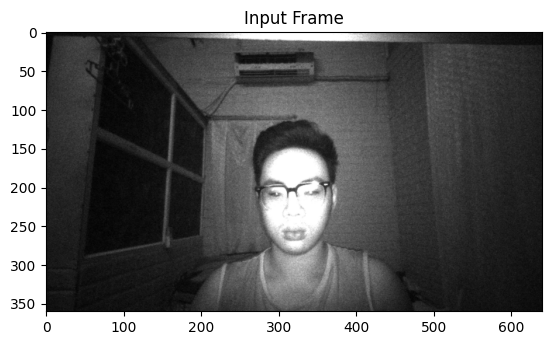

Verification Result: False
Model prediction of matching for each validation image: [0.5857231616973877, 0.5783527493476868, 0.5831221342086792, 0.5813862681388855]


In [101]:

# Ask who is trying to sign in
name = input("Who are you")

# Initialize the webcam
cap = cv2.VideoCapture(CAM_ID)
# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Loop through every frame in the webcam feed
while cap.isOpened():
    
    ret, frame = cap.read()
    if not ret:
        break



    # Display the frame
    cv2.imshow('Face Verification App, press v to capture', frame)

    # Check for key presses
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('v'):
        # Detect face in the frame then crop to 250x250 around the face and save to 'data/positive'
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)
        if len(faces) > 0:
            (x, y, w, h) = faces[0]
            cropped_face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(cropped_face, (250, 250))
        
            # Run verification
            # with the input image take directly from the webcam, the validation images are taken from the validation_images/name_that_user_input folder
            results, verification = verify(resized_face, name, model, 0.7, 0.7, 4)

            # Arguemnt: 0.7, 0.7, 2
            # 0.7: Detection threshold
            # 0.7: Verification threshold
            # 2: Limit the number of images to compare to when validation
            
            # print the result
            # Print the input frame
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title("Input Frame")
            plt.show()


            #Print out the result
            print("Verification Result:", verification)
            results = np.array(results).flatten().tolist()
            print("Model prediction of matching for each validation image:", results)



    

        else:
            # Show a dialog if no faces are detectedq
            print("No faces detected, look at the camera and cpature the image again")

        break


cap.release()
cv2.destroyAllWindows()
